# Implementation of Triplet Loss to classify Images using Keras

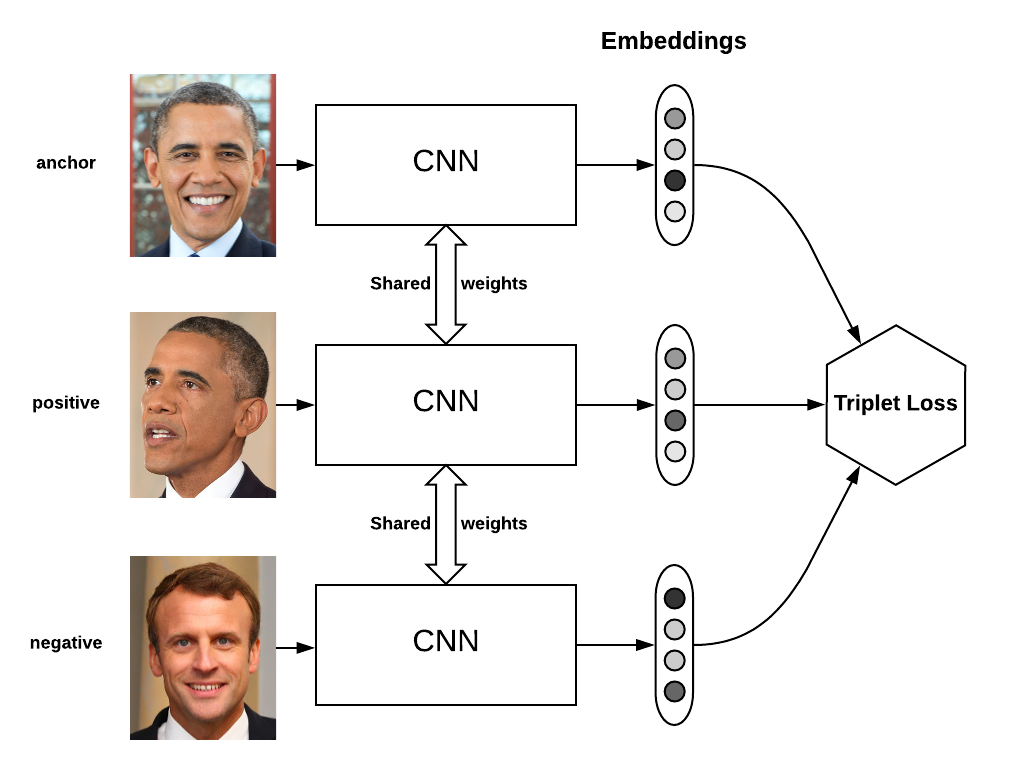

1. Triplet loss is a loss function for artificial neural networks where a baseline (anchor) input is compared to a positive (truthy) input and a negative (falsy) input. The distance from the baseline (anchor) input to the positive (truthy) input is minimized, and the distance from the baseline (anchor) input to the negative (falsy) input is maximized
2. I am going to use it for learning similarity for the purpose of learning embeddings for my three classes that is Cat, Dog and Table

The loss function can be described using a Euclidean distance function

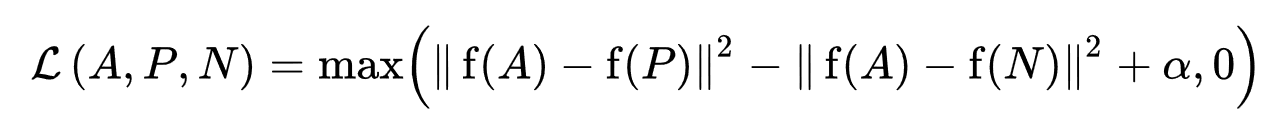

where A is an anchor input, P is a positive input of the same class as A, N is a negative input of a different class from A , α is a margin between positive and negative pairs, and f is an embedding.

This can then be used in a cost function, that is the sum of all losses, which can then be used for minimization of the posed optimization problem

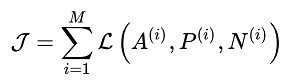

In [1]:
from scipy import ndimage, misc, hstack
import random
import h5py
from shutil import unpack_archive
from sklearn.preprocessing import LabelBinarizer
from itertools import permutations
import numpy as np
import os
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [5]:

cat_xs = []
cat_ys = []


with open(r"/notebooks/TripLetNetwork/cat/cat_boxes.txt") as f:
    for line in f:
        cat_xs.append(r"/notebooks/TripLetNetwork/cat/images/" + line.split()[0])
        cat_ys.append(0)


cat_train_xs = cat_xs[:int(len(cat_xs) * 0.9)]
cat_train_ys = cat_ys[:int(len(cat_xs) * 0.9)]

cat_val_xs = cat_xs[-int(len(cat_xs) * 0.1):]
cat_val_ys = cat_ys[-int(len(cat_xs) * 0.1):]



In [6]:


dog_xs = []
dog_ys = []


with open(r"/notebooks/TripLetNetwork/dog/dog_boxes.txt") as f:
    for line in f:
        dog_xs.append(r"/notebooks/TripLetNetwork/dog/images/" + line.split()[0])
        dog_ys.append(1)

dog_train_xs = dog_xs[:int(len(dog_xs) * 0.9)]
dog_train_ys = dog_ys[:int(len(dog_xs) * 0.9)]

dog_val_xs = dog_xs[-int(len(dog_xs) * 0.1):]
dog_val_ys = dog_ys[-int(len(dog_xs) * 0.1):]



In [7]:


table_xs = []
table_ys = []


with open(r"/notebooks/TripLetNetwork/table/table_boxes.txt") as f:
    for line in f:
        table_xs.append(r"/notebooks/TripLetNetwork/table/images/" + line.split()[0])
        table_ys.append(2)


table_train_xs = table_xs[:int(len(table_xs) * 0.9)]
table_train_ys = table_ys[:int(len(table_xs) * 0.9)]

table_val_xs = table_xs[-int(len(table_xs) * 0.1):]
table_val_ys = table_ys[-int(len(table_xs) * 0.1):]


In [8]:
x_train= hstack((cat_train_xs,dog_train_xs,table_train_xs))
y_train= hstack((cat_train_ys,dog_train_ys,table_train_ys))
x_test= hstack((cat_val_xs,dog_val_xs,table_val_xs))
y_test= hstack((cat_val_ys,dog_val_ys,table_val_ys))

In [14]:
x_train_out=[]
x_test_out=[]
y_train_out=[]
y_test_out=[]

for i in range(len(x_train)):
    image_read = misc.imread(x_train[i])
    
    if(image_read.shape==(64,64,3)):
        x_train_out.append(image_read)
        if(x_train[i].split('/')[3]=='cat'):
            y_train_out.append(0)
        elif(x_train[i].split('/')[3]=='dog'):
            y_train_out.append(1)
        elif(x_train[i].split('/')[3]=='table'):
            y_train_out.append(2)

for i in range(len(x_test)):
    image_read = misc.imread(x_test[i])
    
    if(image_read.shape==(64,64,3)):
        x_test_out.append(image_read)
        if(x_test[i].split('/')[3]=='cat'):
            y_test_out.append(0)
        elif(x_test[i].split('/')[3]=='dog'):
            y_test_out.append(1)
        elif(x_test[i].split('/')[3]=='table'):
            y_test_out.append(2)
        
x_train_out=np.array(x_train_out)
x_test_out=np.array(x_test_out)
y_train_out=np.array(y_train_out)
y_test_out=np.array(y_test_out)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [17]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 3))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each class.
    txts = []
    for i in range(3):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [18]:
x_train_flat = x_train_out.reshape(-1,12288)
x_test_flat = x_test_out.reshape(-1,12288)

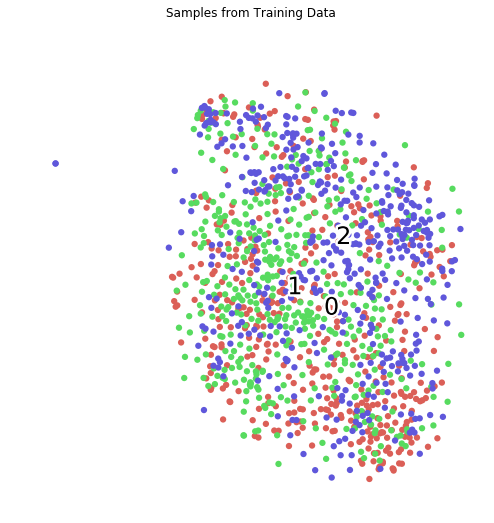

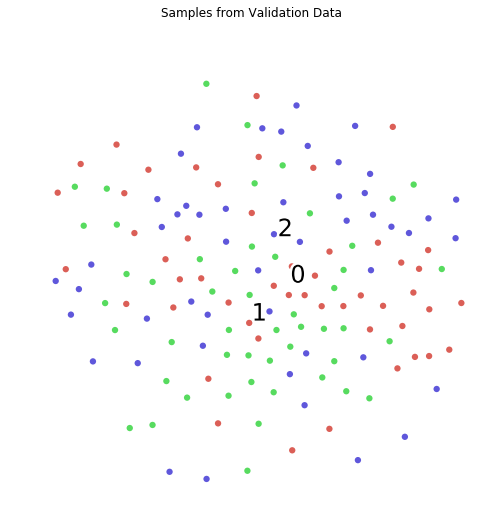

In [20]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat)
scatter(train_tsne_embeds, y_train_out, "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_test_flat)
scatter(eval_tsne_embeds, y_test_out, "Samples from Validation Data")

In [21]:
Classifier_input = Input((12288,))
Classifier_output = Dense(3, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

In [22]:
le = LabelBinarizer()
y_train_onehot = le.fit_transform(y_train_out)
y_test_onehot = le.transform(y_test_out)

In [23]:
Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
Classifier_model.fit(x_train_flat,y_train_onehot, validation_data=(x_test_flat,y_test_onehot),epochs=10)

Train on 1334 samples, validate on 150 samples
Epoch 1/10
1334/1334 [==============================] - 2s 1ms/step - loss: 10.6857 - acc: 0.3366 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 2/10
1334/1334 [==============================] - 0s 112us/step - loss: 10.6810 - acc: 0.3373 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 3/10
1334/1334 [==============================] - 0s 108us/step - loss: 10.6810 - acc: 0.3373 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 4/10
1334/1334 [==============================] - 0s 108us/step - loss: 10.6810 - acc: 0.3373 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 5/10
1334/1334 [==============================] - 0s 105us/step - loss: 10.6810 - acc: 0.3373 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 6/10
1334/1334 [==============================] - 0s 115us/step - loss: 10.6810 - acc: 0.3373 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 7/10
1334/1334 [==============================] - 0s 117us/step - loss: 10.6810 - acc: 0.3373 - val_loss: 10.7454 - val_a

In [25]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    #data_xy is a tuple in which the first element of tuple is all the encoded images 
    #and second element is their classes
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    
    #iterating through the classes in my dataset, I have three classes i.e Cat =0, Dog =1, Table =2
    for data_class in sorted(set(data_xy[1])):
        
        #Selecting the same class index value and different class index value from the data_xy tuple
        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        
        #Generating Anchor-Positive pairs
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) 
        
        #Storing the index of Classes which are different from the current selected class in for loop
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #building a training triplet pairs
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        
        #building a testing triplet pairs
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [26]:
X_train, X_test = generate_triplet(x_train_flat,y_train_out, ap_pairs=150, an_pairs=150,testsize=0.2)

In [27]:
X_train.shape

(54000, 3, 12288)

## Triplet NN

In [28]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    
    print('y_pred.shape = ',y_pred)
    
    total_length = y_pred.shape.as_list()[-1]

    
    anchor = y_pred[:,0:int(total_length*1/3)]
    positive = y_pred[:,int(total_length*1/3):int(total_length*2/3)]
    negative = y_pred[:,int(total_length*2/3):int(total_length*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [29]:
def create_base_network(in_dims):
    # Base network to be shared
    
    model = Sequential()
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(4,name='embeddings'))
    
    
    return model

In [30]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [31]:
anchor_input = Input((64,64,3, ), name='anchor_input')
positive_input = Input((64,64,3, ), name='positive_input')
negative_input = Input((64,64,3, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([64,64,3,])


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

y_pred.shape =  Tensor("merged_layer/concat:0", shape=(?, 12), dtype=float32)


In [32]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4)            1100548     anchor_input[0][0]               
                                                                 positive_input[0][0]       

In [34]:
Anchor = X_train[:,0,:].reshape(-1,64,64,3)
Positive = X_train[:,1,:].reshape(-1,64,64,3)
Negative = X_train[:,2,:].reshape(-1,64,64,3)
Anchor_test = X_test[:,0,:].reshape(-1,64,64,3)
Positive_test = X_test[:,1,:].reshape(-1,64,64,3)
Negative_test = X_test[:,2,:].reshape(-1,64,64,3)

Y_dummy = np.empty((Anchor.shape[0],30))
Y_dummy2 = np.empty((Anchor_test.shape[0],30))

model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=256, epochs=20)

Train on 54000 samples, validate on 13500 samples
Epoch 1/20
54000/54000 [==============================] - 297s 5ms/step - loss: 3.5281 - val_loss: 23.2276
Epoch 2/20
54000/54000 [==============================] - 281s 5ms/step - loss: 0.0459 - val_loss: 23.1480
Epoch 3/20
54000/54000 [==============================] - 281s 5ms/step - loss: 0.2643 - val_loss: 30.5898
Epoch 5/20
54000/54000 [==============================] - 281s 5ms/step - loss: 0.1200 - val_loss: 35.5386
Epoch 6/20
54000/54000 [==============================] - 281s 5ms/step - loss: 0.0438 - val_loss: 32.6602
Epoch 7/20
54000/54000 [==============================] - 281s 5ms/step - loss: 0.0382 - val_loss: 41.6827
Epoch 8/20
54000/54000 [==============================] - 281s 5ms/step - loss: 0.1235 - val_loss: 44.4916
Epoch 9/20
54000/54000 [==============================] - 281s 5ms/step - loss: 0.1116 - val_loss: 54.4276
Epoch 10/20
54000/54000 [==============================] - 281s 5ms/step - loss: 0.0516 - val_

In [46]:
model.save('Triplet_embed.hdf5')

In [47]:
new_model= Model(inputs=anchor_input, outputs=encoded_anchor)

In [48]:
new_model.load_weights('Triplet_embed.hdf5')

In [49]:
tsne = TSNE()
X_train_trm = new_model.predict(x_train_out.reshape(-1,64,64,3))
X_test_trm = new_model.predict(x_test_out.reshape(-1,64,64,3))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

## Let us see the embeddings now

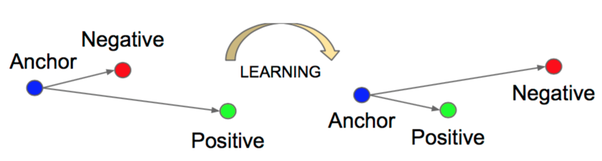

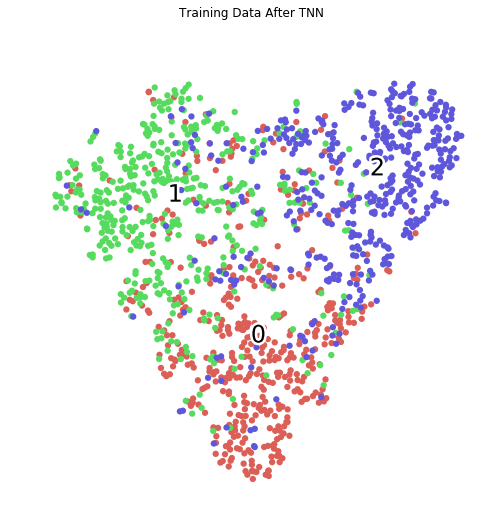

In [50]:
scatter(train_tsne_embeds, y_train_out, "Training Data After TNN")

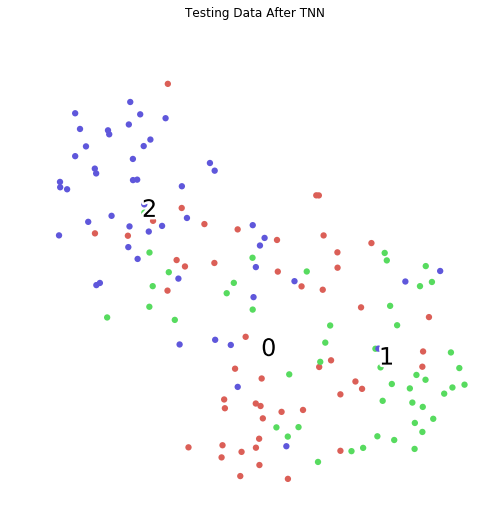

In [51]:
scatter(eval_tsne_embeds, y_test_out, "Testing Data After TNN")

In [43]:
X_train_trm = new_model.predict(x_train_out.reshape(-1,64,64,3))
X_test_trm = new_model.predict(x_test_out.reshape(-1,64,64,3))

Classifier_input = Input((4,))
Classifier_output = Dense(3, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)


Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Classifier_model.fit(X_train_trm,y_train_onehot, validation_data=(X_test_trm,y_test_onehot),epochs=40)

Train on 1334 samples, validate on 150 samples
Epoch 1/40
1334/1334 [==============================] - 0s 206us/step - loss: 3.7125 - acc: 0.3531 - val_loss: 3.0663 - val_acc: 0.3933
Epoch 2/40
1334/1334 [==============================] - 0s 91us/step - loss: 3.2727 - acc: 0.3711 - val_loss: 2.6405 - val_acc: 0.3933
Epoch 3/40
1334/1334 [==============================] - 0s 90us/step - loss: 2.8700 - acc: 0.3913 - val_loss: 2.2738 - val_acc: 0.4267
Epoch 4/40
1334/1334 [==============================] - 0s 91us/step - loss: 2.5277 - acc: 0.4168 - val_loss: 1.9860 - val_acc: 0.4667
Epoch 5/40
1334/1334 [==============================] - 0s 90us/step - loss: 2.2347 - acc: 0.4423 - val_loss: 1.7653 - val_acc: 0.4800
Epoch 6/40
1334/1334 [==============================] - 0s 91us/step - loss: 1.9884 - acc: 0.4625 - val_loss: 1.5931 - val_acc: 0.4933
Epoch 7/40
1334/1334 [==============================] - 0s 90us/step - loss: 1.7847 - acc: 0.4790 - val_loss: 1.4443 - val_acc: 0.5000
Epoch 8

In [47]:
image_input = misc.imread(r"/notebooks/TripLetNetwork/table/images/n03201208_6.JPEG")
Xnew = new_model.predict(image_input.reshape(-1,64,64,3))
y_pred=Classifier_model.predict(Xnew)
final=np.argmax(y_pred,axis=1)
if(final==0):
    print("Its a Cat")
elif(final==1):
    print("Its a Dog")
else:
    print("Its a Table")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Its a Table


In [48]:
Classifier_model.save('Prediction_model.hdf5')